In [1]:
import functools
import ast

import numpy as np
import pandas as pd

import numpy_financial as npf

from ipywidgets import (interact, interactive, fixed, interact_manual,
                        FloatSlider, FloatLogSlider, IntSlider, HTML,
                        AppLayout, VBox, HBox, Dropdown, Label)

from utils import get_sheet, clean_string, default_params

# Pulling data from the original spreadsheet

In [2]:
sheets = {
    'natural_gas': get_sheet('C1 - Natural Gas'),
    'c2': get_sheet('C2 - Electric Kiln (Solar) '),
    'report_data': get_sheet('Report Data'),
    'economic_parameters': get_sheet('Economic Parameters'),
    'eai_data': get_sheet('EIA Data Annual Energy Outlook'),
    'case_summary': get_sheet('Case Summary with Embodied')
}


conversions = {
    'mmBTU/GJ': sheets['natural_gas']['H48'],
    'kg/lbs': sheets['natural_gas']['H49']
}

,scenario,Low,High
0,1,225.84,395
1,2A,470.00,658
2,2B,495.00,685
3,2C,493.00,890
4,3A,399.00,562


Text(0, 0.5, 'Cost [$/tCO2]')

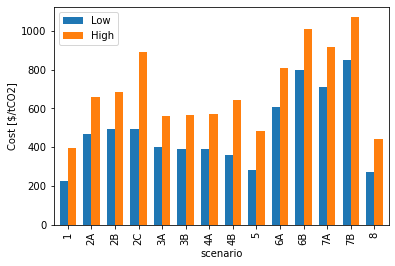

In [3]:
# open the sheet

# pull a table into a Pandas DataFrame
df = sheets['case_summary']['B7:Q20']

# a bit of munging...
df = df[[1, 2, 3]]
df.columns = ['scenario', 'Low', 'High']
# strings -> floats
df = df.apply(clean_string)

# show the first few rows
display(df.head())

# make a quick bar plot
ax = df.set_index('scenario').plot.bar(width=.7)
ax.set_ylabel('Cost [$/tCO2]')

# Working backwards

Goal: start with a single value in the spreadsheet that we'd like the API to calculate. Trace its algorithmic path, using data from the spreadhseet when necessary to gradually develop the API.

### Collect model parameters

In [4]:
def table_to_df(df):
    header = df.iloc[0].str.strip()
    df = df[1:].rename(columns=header).set_index(header[0]).apply(clean_string)
    df.index = df.index.str.strip()  # this assumes the index is a string dtype
    return df


In [5]:
def get_eia_data():
    eai_df = sheets['eai_data']['B4:I17'].pipe(table_to_df)

    # add round trip efficiency and co2 equivalent conversions
    df = sheets['eai_data']['B19:I25'].apply(clean_string).set_index(0)
    df.columns = eai_df.columns
    df.loc['Efficiency (Thermal or Round Trip)'] /= 100
    eai_df = eai_df.append(df)

    # add availability
    avail = sheets['eai_data']['B27:I27'].apply(clean_string).set_index(0)
    avail.index = ['Availability']
    avail.columns = eai_df.columns
    avail.loc['Availability'] /= 100
    eai_df = eai_df.append(avail)
    
    return eai_df
    
eai_df = get_eia_data()
eai_df

,Wind,Advanced NGCC,NGCC w/ CCS,Advanced Nuclear,Solar,Battery Storage,Geothermal EIA 2020
Overnight Cost [$/kW],1319.00,954.0000,2569.0000,6317.00,1331.000,1383.00,2680.00
Plant Size [MW],200.00,1083.0000,377.0000,2156.00,150.000,50.00,50.00
Base Plant Cost [M$],263.80,1033.2000,968.5000,13619.50,199.700,69.20,134.00
Battery Capacity [MWhr],NaN,NaN,NaN,NaN,NaN,200.00,NaN
Lead Time [Years],3.00,3.0000,3.0000,6.00,2.000,1.00,4.00
Variable O&M [$/MWhr],0.00,1.8600,5.8200,2.36,0.000,0.00,1.16
Fixed O&M [$/kW-yr],26.22,12.1500,27.4800,121.13,15.190,24.70,113.29
Base Plant Annual Fixed O&M [$M],5.24,13.1600,10.3600,261.16,2.280,1.24,5.66
Final Heat Rate [BTU/kWh],NaN,6370.0000,7124.0000,10461.00,NaN,NaN,9156.00
Capacity Factor,43.00,87.0000,87.0000,90.00,31.000,NaN,NaN


In [33]:
params = default_params(sheets, 'low')
params['Total Capex [$]'] = sheets['report_data']['H27']
params

{'Scale [tCO2/year]': 1000000,
 'DAC Capacity Factor': 0.9,
 'DAC Section Lead Time [years]': 3,
 'Total Capex [$]': 936,
 'Electric Power Requierement [MW]': 46.6,
 'Thermal [GJ/tCO2]': 6.64,
 'Fixed O+M Costs [$/tCO2]': 34,
 'Varible O+M Cost [$/tCO2]': 4,
 'Economic Lifetime [years]': 20,
 'WACC [%]': 0.085,
 'Natural Gas Cost [$/mmBTU]': 3.43}

In [7]:
# Project Lead Time Escalation of Overnight EPC Costs
def calc_lead_time_mult(rate, time):
    '''replaces cells =Q5:AB158 in `WACC Table Project Lead Time`'''
    vals = np.zeros(time)
    vals[0] = (1+rate)*(1/time)
    # there is almost certainly a better way to express this
    for t in range(1, time):
        vals[t] = np.sum(vals[:t]) * rate + (1+rate)*(1/time)
    return vals.sum()


def nas_report_table_511(params):
    # Capacity [MtCO2/yr]
    capacity = 1.
    
    # Required Thermal Energy [GJ/tCO2]
    # Parameter: =+'Report Data'!E67
    req_thermal_energy_gj = params['Thermal [GJ/tCO2]']
    # Thermal [GJ]
    # Required Thermal Energy [mmBTU/tCO2]
    # Equation: =C84*$H$48
    req_thermal_energy_mmbtu = req_thermal_energy_gj * conversions['mmBTU/GJ']
    
    # Natural Gas [mmBTU]
    # Equation: =C86*'Report Data'!C3
    natural_gas = req_thermal_energy_mmbtu * params['Scale [tCO2/year]']
    
    # Emissions [tCO2/year]
    # Flue Gas Capture Power [MWh/tCO2]
    # Necessary Power [MWh]
    # Power Plant Requirements [MW]
    return {
        'capacity': capacity,
        'natural_gas': natural_gas
    }

In [8]:
scaling_factors = sheets['economic_parameters']['E4:F14'].pipe(table_to_df)
scaling_scenarios = {
    'Advanced NGCC': 'Natural Gas Energy',
    'NGCC w/ CCS': 'Natural Gas Energy',
    'Solar': 'Solar Energy',
    'Wind': 'Wind Energy',
    'Battery Storage': 'Battery Storage',
#     'Advanced Nuclear': 'Nuclear (EIA Scalar for Large PWR)',  # could also be Nuclear (Small Modular Nuclear Reactors)	
}

percent_capture = {
    'NGCC w/ CCS': sheets['natural_gas']['H34']
}

# temporary fix...
# eventually, we should set this to params['Electric Power Requierement [MW]'] as a function of scenario & high/low-case
base_electric_requirements = {
    'NGCC w/ CCS': sheets['report_data']['C58'],  # low,
    'Solar': sheets['report_data']['C64'],  # low
    'Wind': sheets['report_data']['C64']  # low
}

base_thermal_requirements = {
    'NGCC w/ CCS': 0.,  # hardcoded,
    'Advanced NGCC': 0, 
    'Solar': sheets['c2']['F18'],  # low
    'Wind': sheets['c2']['F18']  # low  (same as Solar)
}

In [9]:
def calc_battery_requirements(base_energy_req, e_vals, params):
    v = {}
    
    # Battery Capacity [MWh]
    # TODO: move to params (sheets['report_data']['C64'])
    v['Battery Capacity [MWh]'] =  base_energy_req * (24 * (1 - e_vals['Planned Capacity Factor']) )  

    # Round Trip Effciency
    v['Round Trip Effciency'] = eai_df.loc['Efficiency (Thermal or Round Trip)', 'Battery Storage']

    # Battery Capacity Needed [MWh]
    v['Battery Capacity Needed [MWh]'] = v['Battery Capacity [MWh]'] / v['Round Trip Effciency']
    
    # Increased [MWh]
    v['Increased [MWh]'] = v['Battery Capacity Needed [MWh]'] - v['Battery Capacity [MWh]']
    
    # Increased Solar/Wind Need
    v['Increased Need [MW]'] = v['Increased [MWh]'] / (24 * e_vals['Planned Capacity Factor'])
    
    # Battery Capital Cost [M$]
    v['Battery Capital Cost [M$]'] = eai_df.loc['Base Plant Cost [M$]', 'Battery Storage'] * (v['Battery Capacity Needed [MWh]'] / eai_df.loc['Battery Capacity [MWhr]', 'Battery Storage']) ** scaling_factors.loc['Battery Storage', 'Scaling Factor']

    # Battery Fixed O&M [$/tCO2eq]
    v['Battery Fixed O&M [$/tCO2eq]'] = (eai_df.loc['Base Plant Annual Fixed O&M [$M]', 'Battery Storage'] * (v['Battery Capacity Needed [MWh]'] / eai_df.loc['Battery Capacity [MWhr]', 'Battery Storage']) ** scaling_factors.loc['Battery Storage', 'Scaling Factor']) *1e6 / params['Scale [tCO2/year]']

    # Battery Variable O&M [$/tCO2eq]
    v['Battery Variable O&M [$/tCO2eq]'] = eai_df.loc['Variable O&M [$/MWhr]', 'Battery Storage'] * v['Battery Capacity [MWh]'] / params['Scale [tCO2/year]'] * 365
    
    return v

In [10]:
def energy_requirements(base_energy_requirement, params, scenario='NGCC w/ CCS'):
    '''
    Calculate the energy requirements of a single component of a DAC system (e.g. electric or thermal)
    
    Parameters
    ----------
    base_energy_requirement : float
        Baseline energy demand [MW].
        This parameter is refered to as `Electric Power Requierement [MW]` or `Thermal [MW]` or `Low Value Case`.
    
    params : dict
        Dictionary of parameters.
        
    scenario : str
        Generation technology.
    '''
    
    v = {}
    
    # Operational Hours [h/yr]
    operational_hours = params['DAC Capacity Factor'] * 365 * 24
    
    # Planned Capacity Factor
    v['Planned Capacity Factor'] = eai_df.loc['Availability', scenario]
    
    # Electric Power Requierement [MW]
    # aka low value case in C1
    v['Base Energy Requierement [MW]'] = base_energy_requirement

    # calcuate battery params now
    # For now, I'm just computing the battery requirements when the capacity is less than 1. Will need to revisit for C2C.
    if v['Planned Capacity Factor'] < 1:
        v.update(calc_battery_requirements(v['Base Energy Requierement [MW]'], v, params))
    
    # Plant Size [MW]
    v['Plant Size [MW]'] = (v['Base Energy Requierement [MW]'] / v['Planned Capacity Factor']) + v.get('Increased Need [MW]', 0.)
    
    # Overnight Cost [M$]
    scaling_key = scaling_scenarios[scenario]
    v['Overnight Cost [M$]'] = eai_df.loc['Base Plant Cost [M$]', scenario] * (v['Plant Size [MW]'] / eai_df.loc['Plant Size [MW]', scenario])**scaling_factors.loc[scaling_key, 'Scaling Factor']
    
    # Lead Time Multiplier
    v['Lead Time Multiplier'] = calc_lead_time_mult(params['WACC [%]'], int(eai_df.loc['Lead Time [Years]', scenario]))  # Note: this leads to rounding differences that are non-trivial   

    # Capital Cost [M$] 
    v['Capital Cost [M$]'] = v['Overnight Cost [M$]'] * v['Lead Time Multiplier']
    
    # Total Capital Cost [M$]
    v['Total Capital Cost [M$]'] = v['Capital Cost [M$]'] + v.get('Battery Capital Cost [M$]', 0.)

    # Annual Capital Recovery Factor
    annual_capital_recovery_factor = -npf.pmt(params['WACC [%]'], params['Economic Lifetime [years]'], 1)
    
    # Capital Recovery [$/tCO2eq]
    v['Capital Recovery [$/tCO2eq]'] = v['Total Capital Cost [M$]'] * annual_capital_recovery_factor * 1e6 / params['Scale [tCO2/year]']
    
    # Power Fixed O&M [$/tCO2eq]
    v['Power Fixed O&M [$/tCO2eq]'] = (eai_df.loc['Base Plant Annual Fixed O&M [$M]', scenario] * (v['Plant Size [MW]'] / eai_df.loc['Plant Size [MW]', scenario]) ** scaling_factors.loc[scaling_key, 'Scaling Factor']) * 1e6 / params['Scale [tCO2/year]']

    # Power Variable O&M [$/tCO2eq]
    v['Power Variable O&M [$/tCO2eq]'] = eai_df.loc['Variable O&M [$/MWhr]', scenario] * v['Plant Size [MW]'] * operational_hours / params['Scale [tCO2/year]']
   
    # Total Fixed O&M [$/tCO2eq]
    v['Total Fixed O&M [$/tCO2eq]'] = v['Power Fixed O&M [$/tCO2eq]'] + v.get('Battery Fixed O&M [$/tCO2eq]', 0.)
    
    # Total Variable O&M [$/tCO2eq]
    v['Total Variable O&M [$/tCO2eq]'] = v['Power Variable O&M [$/tCO2eq]'] + v.get('Battery Variable O&M [$/tCO2eq]', 0.)
   
    # Natural Gas Use [mmBTU/tCO2eq]
    heat_rate = eai_df.loc['Final Heat Rate [BTU/kWh]', scenario]
    if pd.notnull(heat_rate):
        v['Natural Gas Use [mmBTU/tCO2eq]'] = operational_hours * v['Plant Size [MW]'] * 1000 * eai_df.loc['Final Heat Rate [BTU/kWh]', scenario] / 1e6 / params['Scale [tCO2/year]']
    else:
        v['Natural Gas Use [mmBTU/tCO2eq]'] = 0.
    
    # Natural Gas Cost [$/tCO2eq]
    v['Natural Gas Cost [$/tCO2eq]'] = v['Natural Gas Use [mmBTU/tCO2eq]'] * params['Natural Gas Cost [$/mmBTU]']
    
    # Emitted tCO2eq/tCO2
    v['Emitted tCO2eq/tCO2'] = v['Natural Gas Use [mmBTU/tCO2eq]'] * eai_df.loc['Total CO2 eq [lb/mmbtu]', scenario] * 0.454 / 1000 * (1 - percent_capture.get(scenario, 0.))
    
    # Total Cost [$/tCO2eq gross]
    v['Total Cost [$/tCO2eq gross]'] = v['Capital Recovery [$/tCO2eq]'] + v['Total Fixed O&M [$/tCO2eq]'] + v['Total Variable O&M [$/tCO2eq]']
    
    # Total Cost [$/tCO2eq net]
    v['Total Cost [$/tCO2eq net]'] = v['Total Cost [$/tCO2eq gross]'] / (1 - v['Emitted tCO2eq/tCO2'])  # TODO: K62 is the tCO2eq/tCO2 field from the thermal section
    
    return v

In [19]:
# e = pd.DataFrame({s: energy_requirements(base_electric_power_requirements[s], params, scenario=s) for s in ['NGCC w/ CCS', 'Solar', 'Wind']})
# t = pd.DataFrame({s: energy_requirements(base_thermal_requirements[s], params, scenario=s) for s in ['NGCC w/ CCS', 'Solar', 'Wind']})

# energy_block = pd.concat({'electric': e, 'thermal': t}, axis=1)
# energy_block

scenario = 'Wind'
ev = energy_requirements(base_electric_requirements[scenario], params, scenario=scenario)
tv = energy_requirements(base_thermal_requirements[scenario], params, scenario=scenario)

pd.Series(ev).to_frame()

,0
Planned Capacity Factor,0.520000
Base Energy Requierement [MW],37.700000
Battery Capacity [MWh],434.304000
Round Trip Effciency,0.850000
Battery Capacity Needed [MWh],510.945882
Increased [MWh],76.641882
Increased Need [MW],6.141176
Battery Capital Cost [M$],168.687832
Battery Fixed O&M [$/tCO2eq],3.022730
Battery Variable O&M [$/tCO2eq],0.000000


In [12]:
def combined_power_block_requirements(ev, tv, params, scenario):
    '''this is probably only useful when the electric/thermal blocks are from the same source'''
    
    v = {}
    
    # Operational Hours [h/yr]
    operational_hours = params['DAC Capacity Factor'] * 365 * 24
    
    # Power Plant Size
    v['Plant Size [MW]'] = ev['Plant Size [MW]'] + tv['Plant Size [MW]']

    # Overnight Cost [M$]
    scaling_key = scaling_scenarios[scenario]
    v['Overnight Cost [M$]'] = eai_df.loc['Base Plant Cost [M$]', scenario] * (v['Plant Size [MW]'] / eai_df.loc['Plant Size [MW]', scenario])**scaling_factors.loc[scaling_key, 'Scaling Factor']

    # Lead Time Multiplier
    v['Lead Time Multiplier'] = calc_lead_time_mult(params['WACC [%]'], int(eai_df.loc['Lead Time [Years]', scenario]))

    # Capital Cost [M$] 
    v['Capital Cost [M$]'] = v['Overnight Cost [M$]'] * v['Lead Time Multiplier']

    # Power Fixed O&M [$/tCO2eq]
    v['Power Fixed O&M [$/tCO2eq]'] = (eai_df.loc['Base Plant Annual Fixed O&M [$M]', scenario] * (v['Plant Size [MW]'] / eai_df.loc['Plant Size [MW]', scenario]) ** scaling_factors.loc[scaling_key, 'Scaling Factor']) * 1e6 / params['Scale [tCO2/year]']

    # Power Variable O&M [$/tCO2eq]
    v['Power Variable O&M [$/tCO2eq]'] = eai_df.loc['Variable O&M [$/MWhr]', scenario] * v['Plant Size [MW]'] * operational_hours / params['Scale [tCO2/year]']

    # Battery Capacity [MWh]
    v['Battery Capacity [MWh]'] = ev['Battery Capacity Needed [MWh]'] + tv['Battery Capacity Needed [MWh]']

    # Battery Capital Cost [M$]
    v['Battery Capital Cost [M$]'] = eai_df.loc['Base Plant Cost [M$]', 'Battery Storage'] * (v['Battery Capacity [MWh]'] / eai_df.loc['Battery Capacity [MWhr]', 'Battery Storage']) ** scaling_factors.loc['Battery Storage', 'Scaling Factor']

    # Battery Fixed O&M [$/tCO2eq]
    v['Battery Fixed O&M [$/tCO2eq]'] = (eai_df.loc['Base Plant Annual Fixed O&M [$M]', 'Battery Storage'] * (v['Battery Capacity [MWh]'] / eai_df.loc['Battery Capacity [MWhr]', 'Battery Storage']) ** scaling_factors.loc['Battery Storage', 'Scaling Factor']) *1e6 / params['Scale [tCO2/year]']

    # Battery Variable O&M [$/tCO2eq]
    v['Battery Variable O&M [$/tCO2eq]'] = eai_df.loc['Variable O&M [$/MWhr]', 'Battery Storage'] * v['Battery Capacity [MWh]'] / params['Scale [tCO2/year]'] * 365

    # Total Capital Cost [M$]
    v['Total Capital Cost [M$]'] = v['Capital Cost [M$]'] +  v['Battery Capital Cost [M$]']

    # Annual Capital Recovery Factor
    annual_capital_recovery_factor = -npf.pmt(params['WACC [%]'], params['Economic Lifetime [years]'], 1)
    
    # Capital Recovery [$/tCO2eq]
    v['Capital Recovery [$/tCO2eq]'] = v['Total Capital Cost [M$]'] * annual_capital_recovery_factor * 1e6 / params['Scale [tCO2/year]']

    # Fixed O+M [$/tCO2eq]
    v['Fixed O+M [$/tCO2eq]'] = v['Power Fixed O&M [$/tCO2eq]'] + v['Battery Fixed O&M [$/tCO2eq]']

    # Variable O+M [$/tCO2eq]
    v['Variable O+M [$/tCO2eq]'] = v['Power Variable O&M [$/tCO2eq]'] + v['Battery Variable O&M [$/tCO2eq]']
    
    return v

In [18]:
cv = combined_power_block_requirements(ev, tv, params, scenario)
pd.Series(cv).to_frame()

,0
Plant Size [MW],566.758824
Overnight Cost [M$],709.618078
Lead Time Multiplier,1.179838
Capital Cost [M$],837.234404
Power Fixed O&M [$/tCO2eq],14.095522
Power Variable O&M [$/tCO2eq],0.000000
Battery Capacity [MWh],3682.334118
Battery Capital Cost [M$],1101.398881
Battery Fixed O&M [$/tCO2eq],19.736049
Battery Variable O&M [$/tCO2eq],0.000000


In [26]:
def total_energy_block_costs(ev, tv, cv, params):
    
    v = {}
    
    # Total Power Capacity Required [MW]
    v['Total Power Capacity Required [MW]'] = ev['Plant Size [MW]'] + tv['Plant Size [MW]']
    
    # Total Battery Capacity Required [MWh]
    v['Total Battery Capacity Required [MWh]'] = ev['Battery Capacity Needed [MWh]'] + tv['Battery Capacity Needed [MWh]']

    # Total Capital Cost [M$]
    v['Total Capital Cost [M$]'] = cv['Total Capital Cost [M$]']
    
    # Capital Recovery [$/tCO2eq]
    v['Capital Recovery [$/tCO2eq]'] = cv['Capital Recovery [$/tCO2eq]']
    
    # Fixed O+M [$/tCO2eq]
    v['Fixed O+M [$/tCO2eq]'] = cv['Fixed O+M [$/tCO2eq]']

    # Variable O+M [$/tCO2eq]
    v['Variable O+M [$/tCO2eq]'] = cv['Variable O+M [$/tCO2eq]']

    # NG Cost [$/tCO2eq]
    v['Natural Gas Cost [$/tCO2eq]'] = ev['Natural Gas Cost [$/tCO2eq]'] + tv['Natural Gas Cost [$/tCO2eq]']
    
    # Total Cost [$/tCO2]
    v['Total Cost [$/tCO2]'] = v['Capital Recovery [$/tCO2eq]'] + v['Fixed O+M [$/tCO2eq]'] + v['Variable O+M [$/tCO2eq]'] + v['Natural Gas Cost [$/tCO2eq]']
    
    # Net Capture [tCO2/yr]
    v['Net Capture [tCO2/yr]'] = params['Scale [tCO2/year]'] - params['Scale [tCO2/year]'] * (ev['Emitted tCO2eq/tCO2'] + tv['Emitted tCO2eq/tCO2'])
    
    # Total Cost [$/tCO2 net removed]
    v['Total Cost [$/tCO2 net removed]'] = v['Total Cost [$/tCO2]'] / (1 - (ev['Emitted tCO2eq/tCO2'] + tv['Emitted tCO2eq/tCO2']))    
    
    return v

In [27]:
tev = total_energy_block_costs(ev, tv, cv, params)
pd.Series(tev).to_frame()

510.9458823529412 3171.3882352941177


,0
Total Power Capacity Required [MW],566.758824
Total Battery Capacity Required [MWh],3682.334118
Total Capital Cost [M$],1938.633284
Capital Recovery [$/tCO2eq],204.857268
Fixed O+M [$/tCO2eq],33.831571
Variable O+M [$/tCO2eq],0.000000
Natural Gas Cost [$/tCO2eq],0.000000
Total Cost [$/tCO2],238.688839
Net Capture [tCO2/yr],1000000.000000
Total Cost [$/tCO2 net removed],238.688839


In [54]:
def dac_section_costs(ev, tv, params):
    '''This section needs some spot checking. Not sure if we just have some propagating round off differences or something bigger...'''

    v = {}
    
    # Total Overnight Capital Cost [M$]
    v['Total Capital Cost [M$]'] = params['Total Capex [$]']
   
    # Lead Time Multiplier
    v['Lead Time Multiplier'] = calc_lead_time_mult(params['WACC [%]'], params['DAC Section Lead Time [years]'])  # Note: this leads to rounding differences that are non-trivial
    v['Lead Time Multiplier'] = 1.16
    # Capital Cost (including Lead Time) [M$]
    v['Capital Cost (including Lead Time) [M$]'] = v['Total Capital Cost [M$]'] * v['Lead Time Multiplier']

    # Annual Capital Recovery Factor
    recovery_factor = -npf.pmt(params['WACC [%]'], params['Economic Lifetime [years]'], 1)

    # Capital Recovery [$/tCO2eq]
    v['Capital Recovery [$/tCO2eq]'] =  v['Total Capital Cost [M$]'] * recovery_factor * 1e6 / params['Scale [tCO2/year]']
    
    # Fixed O+M [$/tCO2eq]
    v['Fixed O+M [$/tCO2eq]'] = params['Fixed O+M Costs [$/tCO2]']
    
    # Variable O+M [$/tCO2eq]
    v['Variable O+M [$/tCO2eq]'] = params['Varible O+M Cost [$/tCO2]']

    # Total Cost [$/tCO2]
    v['Total Cost [$/tCO2]'] = v['Capital Recovery [$/tCO2eq]'] + v['Fixed O+M [$/tCO2eq]'] + v['Variable O+M [$/tCO2eq]']
    
    # Total Cost [$/tCO2 net removed]
    v['Total Cost [$/tCO2 net removed]'] = v['Total Cost [$/tCO2]'] / (1 - (ev['Emitted tCO2eq/tCO2'] + tv['Emitted tCO2eq/tCO2']))
    
    return v

In [55]:
dv = dac_section_costs(ev, tv, params)
pd.Series(dv).to_frame()

,0
Total Capital Cost [M$],936.000000
Lead Time Multiplier,1.160000
Capital Cost (including Lead Time) [M$],1085.760000
Capital Recovery [$/tCO2eq],98.908032
Fixed O+M [$/tCO2eq],34.000000
Variable O+M [$/tCO2eq],4.000000
Total Cost [$/tCO2],136.908032
Total Cost [$/tCO2 net removed],136.908032


In [56]:
def overall_costs(tev, dv, params):
    v = {}
    
    # Total Capital Cost [M$]
    v['Total Capital Cost [M$]'] = tev['Total Capital Cost [M$]'] + dv['Capital Cost (including Lead Time) [M$]']
    
    # Annual Capital Recovery Factor
    recovery_factor = -npf.pmt(params['WACC [%]'], params['Economic Lifetime [years]'], 1)
    
    # Capital Recovery [$/tCO2eq]
    # =K86*'Economic Parameters'!C6*10^6/'Report Data'!C3
    v['Capital Recovery [$/tCO2eq]'] = v['Total Capital Cost [M$]'] * recovery_factor * 1e6 / params['Scale [tCO2/year]']

    # Fixed O+M [$/tCO2eq]
    v['Fixed O+M [$/tCO2eq]'] = tev['Fixed O+M [$/tCO2eq]'] + dv['Fixed O+M [$/tCO2eq]']

    # Variable O+M [$/tCO2eq]
    v['Variable O+M [$/tCO2eq]'] = tev['Variable O+M [$/tCO2eq]'] + dv['Variable O+M [$/tCO2eq]']

    # Natural Gas Cost [$/tCO2]
    v['Natural Gas Cost [$/tCO2]'] = tev['Natural Gas Cost [$/tCO2eq]']
    
    # Total Cost [$/tCO2]
    v['Total Cost [$/tCO2]'] = v['Capital Recovery [$/tCO2eq]'] + v['Fixed O+M [$/tCO2eq]'] + v['Variable O+M [$/tCO2eq]'] + v['Natural Gas Cost [$/tCO2]']
    
    # Total Cost [$/tCO2 Net Removed]
    v['Total Cost [$/tCO2 Net Removed]'] = tev['Total Cost [$/tCO2 net removed]'] + dv['Total Cost [$/tCO2 net removed]']
    
    return v


ov = overall_costs(tev, dv, params)
pd.Series(ov).to_frame()

,0
Total Capital Cost [M$],3024.393284
Capital Recovery [$/tCO2eq],319.590585
Fixed O+M [$/tCO2eq],67.831571
Variable O+M [$/tCO2eq],4.000000
Natural Gas Cost [$/tCO2],0.000000
Total Cost [$/tCO2],391.422157
Total Cost [$/tCO2 Net Removed],375.596871


In [60]:
def all_in_one(params, scenario='Wind'):
    ev = energy_requirements(base_electric_requirements[scenario], params, scenario=scenario)
    tv = energy_requirements(base_thermal_requirements[scenario], params, scenario=scenario)
    cv = combined_power_block_requirements(ev, tv, params, scenario)
    tev = total_energy_block_costs(ev, tv, cv, params)
    ov = overall_costs(tev, dv, params)

    return ov

In [64]:
cost = all_in_one(params)['Total Cost [$/tCO2]']

510.9458823529412 3171.3882352941177


### TODO:

Leaving off here. Things to do:
- check values from `dac_section` on down.
- move functions into a class that shares params, two scenarios, and eai_df
- methods on this class:
    - recovery_factor
    - Lead Time Multiplier
    - scaling_key
    - 1 method for each block above
    - export to pandas
    - maybe a bit of viz?
- update prototype app below

# Interactive DAC Costing Tool

In [66]:
app_params = params.copy()
rsliders = {}
esliders = {}
all_sliders = {}

labels = {
    'Scale [tCO2/year]': 'Scale [tCO2/year]',
    'DAC Capacity Factor': 'DAC Capacity Factor',
    'DAC Section Lead Time [years]': 'DAC Section Lead Time [years]',
    'Total Capex [$]': 'Overnight Capex [M$] *',
    'Electric Power Requierement [MW]': 'Electric Power Requierement [MW] *',
    'Thermal [GJ/tCO2]': 'Thermal [GJ/tCO2] *',
    'Fixed O+M Costs [$/tCO2]': 'Fixed O+M Costs [$/tCO2]*',
    'Varible O+M Cost [$/tCO2]': 'Varible O+M Cost [$/tCO2] *',
    'Economic Lifetime [years]': 'Economic Lifetime [years]',
    'WACC [%]': 'WACC [%]',
    'Natural Gas Cost [$/mmBTU]': 'Natural Gas Cost [$/mmBTU]',
}


# --------- callbacks --------- #
def update_cost(app_params):
    cost = all_in_one(app_params)['Total Cost [$/tCO2]']
    result.value = f'<h1>${cost:0.2f}<h1/>'


def on_value_change(param, change):
    app_params[param] = change['new']
    update_cost(app_params)


def set_defaults(change):
    case = change['new']
    p = default_params(sheets, case.lower())
    app_params.update(p)
    for k, v in app_params.items():
        if k in all_sliders:
            all_sliders[k].value = v
# --------- callbacks --------- #

            
header = HTML('''
<h1> DAC Cost Estimator </h1>

<b>By NOAH MCQUEEN and JOE HAMMAN</b>

<div style="width:800px"
    <p>
        How much does it cost to build a Direct Air Capture facility? To help answer this question, we've built a calculator that takes the most important variables that drive the cost of building and operating a DAC plant. To find out more about the fundementals and assumptions in the calcuator, check out Noah's paper...
    </p>
</div>
''')

# presets
presets = Dropdown(description='Preset Scenario', options=['Low', 'High'], value='Low')
presets.observe(set_defaults, names='value')

# report data

result = HTML(value=f'<h1>${cost:0.2f}<h1/>')
right = VBox([HTML('<b>You can build this DAC plant for ... </b>'), result])

rsliders['Scale [tCO2/year]'] = FloatLogSlider(min=1, max=12, step=.1, value=sheets['report_data']['C3'])
rsliders['DAC Capacity Factor'] = FloatSlider(min=0, max=1, step=0.01, readout_format='.2%', value=sheets['report_data']['C4'])
rsliders['DAC Section Lead Time [years]'] = IntSlider(min=1, max=6, value=sheets['report_data']['C6'])
rsliders['Total Capex [$]'] = FloatSlider(min=sheets['report_data']['C21'], max=sheets['report_data']['D21'], value=sheets['report_data']['C21'])
rsliders['Electric Power Requierement [MW]'] = FloatSlider(min=sheets['report_data']['C58'], max=sheets['report_data']['D58'], value=sheets['report_data']['C58'])
rsliders['Thermal [GJ/tCO2]'] = FloatSlider(min=sheets['report_data']['E67'], max=sheets['report_data']['F67'], value=sheets['report_data']['E67'])
rsliders['Fixed O+M Costs [$/tCO2]'] = FloatSlider(min=sheets['report_data']['H32'], max=sheets['report_data']['I32'], value=sheets['report_data']['H32'])
rsliders['Varible O+M Cost [$/tCO2]'] = FloatSlider(min=sheets['report_data']['H33'], max=sheets['report_data']['I33'], value=sheets['report_data']['H33'])

for key, slider in rsliders.items():
    slider.observe(functools.partial(on_value_change, key), names='value')

details = HTML('''
<h2>Report Data</h2>

<p>Parameters from the <em>Report Data</em> worksheet...</p>
''')
report_data = VBox([details] + [HBox([Label(labels[k], layout={'width': '250px'}), s]) for k, s in rsliders.items()])


details = HTML('''
<h2>Economic Data</h2>

<p>Parameters from the <em>Economic Parameters</em> worksheet...</p>
''')

# economic parameters
esliders['Economic Lifetime [years]'] = IntSlider(min=1, max=50, value=sheets['economic_parameters']['C4'])
esliders['WACC [%]'] = FloatSlider(min=0, max=1, step=0.01, readout_format='.2%', value=sheets['economic_parameters']['C5'])
esliders['Natural Gas Cost [$/mmBTU]'] = FloatSlider(min=0, max=10, step=0.1, value=sheets['economic_parameters']['C7'])
# esliders['natural_gas_energy_scaling_factor'] = FloatSlider(min=0, max=1, value=sheets['economic_parameters']['F5'])

for key, slider in esliders.items():
    slider.observe(functools.partial(on_value_change, key), names='value')

econ_data = VBox([details] + [HBox([Label(labels[k], layout={'width': '250px'}), s]) for k, s in esliders.items()])

all_sliders = {**rsliders, **esliders}

center = VBox([presets, report_data, econ_data])

app = AppLayout(header=header, center=center, right_sidebar=right, width='900px')

app

AppLayout(children=(HTML(value='\n<h1> DAC Cost Estimator </h1>\n\n<b>By NOAH MCQUEEN and JOE HAMMAN</b>\n\n<d…